# Vanishing/Exploding Gradients Problems

As we discussed in Chapter 10, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step

**Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution**. This is called the vanishing gradients problem. **In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem**, which is mostly encountered in recurrent neural networks. More gener ally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds

A paper titled “Understanding the Difficulty of Training Deep Feedforward Neural Networks” by Xavier Glorot and Yoshua Bengio1 found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time, namely random initialization using a normal distribution with a mean of 0 and a standard deviation of 1. In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks)

Looking at the logistic activation function, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers

<p align='center'>
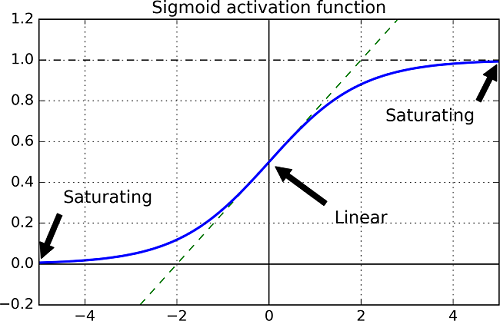
</p>
Figure 11-1. Logistic activation function saturation

## Glorot and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate this problem. We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients

We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction

It is actually not possible to guarantee both unless the layer has an equal
number of inputs and neurons (these numbers are called the fan-in and fan-out of the
layer), but they proposed a good compromise that has proven to work very well in
practice: **the connection weights of each layer must be initialized randomly as described in Equation below, where**

$$fan_{avg}= \frac {(fan_{in} + fan_{out})} {2}$$

This initialization strategy is called Xavier initialization (after the author’s first name) or Glorot initialization (after his last name)

Equation 11-1. Glorot initialization (when using the logistic activation function)

Normal distribution with mean 0 and variance 
$\sigma^2 = \frac {1} {fan_{avg}}$ 

Or a uniform distribution between $-r$ and $+r$, with $r = \sqrt{ \frac {3} {fan_{avg}}}$

If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it LeCun initialization. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$, as shown in Table 11-1





Table 11-1. Initialization parameters for each type of activation function

<p align='center'>
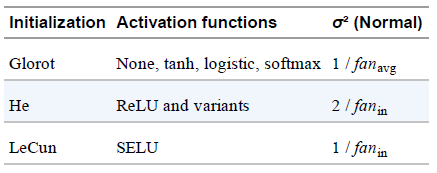
</p>

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting

kernel_initializer="he_uniform" or
kernel_initializer="he_normal" like this:

In [2]:
from tensorflow import keras
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

If you want He initialization with a uniform distribution but based on $fan_{avg}$ rather than $fan_{in}$, you can use the VarianceScaling initializer like this:

In [3]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., 
              mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid',
                   kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function

Other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute)

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, **some neurons effectively “die,” meaning they stop outputting anything other than 0**. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate

A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU

<p align='center'>
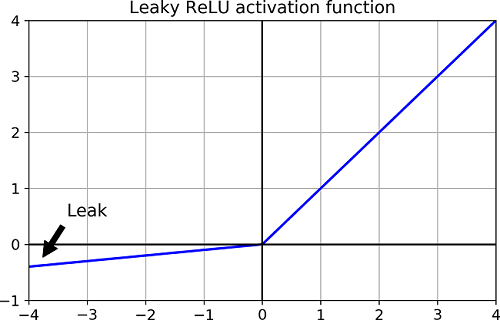
</p>
Figure 11-2. Leaky ReLU: like ReLU, but with a small slope for negative values

Last but not least, a 2015 paper by Djork-Clevert et al. proposed a new activation function called the **exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced**, and the neural network performed better on the test set

Figure 11-3 graphs the function, and Equation 11-2 shows its definition

Equation 11-2. ELU activation function

$$ELU_{\alpha}(z) = \begin{cases}  \alpha(exp(z) - 1) & \text{if } z < 0 \\ z & \text{if } z \geq 0 \end{cases}$$

<p align='center'>
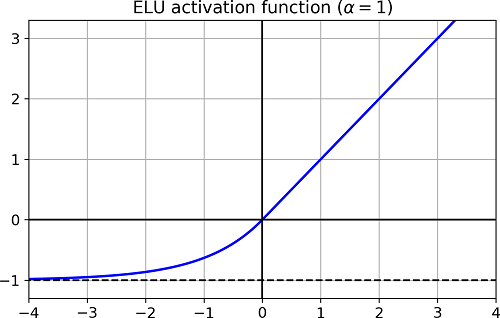
</p>
Figure 11-3. ELU activation function

The ELU activation function looks a lot like the ReLU function, with a few major differences:

* It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem

* The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter

* It has a nonzero gradient for z < 0, which avoids the dead neurons problem

* If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0

The main drawback of the ELU activation function is that it is **slower to compute than the ReLU function and its variants (due to the use of the exponential function)**

Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network


Then, a <a href='https://arxiv.org/abs/1706.02515'>2017 paper</a> by Guter Klambauer et al. introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function

The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem

As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen

* The input features must be standardized (mean 0 and standard deviation 1)

* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal"

* The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions

* The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well

To use the leaky ReLU activation function, create a LeakyReLu layer and add it to your model just after the layer you want to apply it to, 
Let's train a neural network on Fashion MNIST using the Leaky ReLU:



In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation='softmax')         
])

In [6]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy']
              )

In [7]:
#history = model.fit(X_train, y_train, epochs=10,
#                    validation_data=(X_valid, y_valid))

For PreLU, replace LeakyRelu(alpha=0.2) with PReLU()

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [9]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy']
              )

In [10]:
#history = model.fit(X_train, y_train, epochs=10,
#                    validation_data=(X_valid, y_valid))

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training

In a <a href='https://arxiv.org/abs/1502.03167'>2015 paper</a>, Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) that addresses these problems

The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply **zero centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting**

In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, **you do not need to standardize your training set (e.g., using a StandardScaler)**; the BN layer will do it for you

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the **mean and standard deviation of the input over the current mini-batch** (hence the name “Batch Normalization”

The whole operation is summarized step by step in Equation 11-3

Equation 11-3. Batch Normalization algorithm

$$\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)} \\ 
{\sigma_B}^2 = \frac{1}{m_B} \sum^{m_B}_{i=1}(x^{(i)} - \mu_B)^2 \\ 
\hat x^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{{\sigma_B}^2 + \epsilon}} \\
z^{(i)} = \gamma \space \otimes \hat x^{(i)} + \beta $$

In this algorithm:

* $\mu_B$ is the vector of input means, evaluted over the whole mini-batch B (it contains one mean per input)

* $\sigma_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input)

* $m_B$ is the number of instances in the mini-batch

* $\hat x^{(i)}$ is the vector of zero-centered and normalized inputs for instance i

* $\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input)

* $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter)

* $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter

* $\epsilon$ is a tiny number that avoids division by zero (typically $10^{-5}$). This is called a smoothing term

* $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs

So during training, BN standardizes its inputs, then rescales and offsets them. What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation

Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer

These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer

To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagaion, and $\mu$ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average

Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3)

Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout)

Batch Normalization does, however, add some complexity to the model. Moreover, there is a runtime penalty: network makes slower predictions due to the extra computations required at each layer

Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset

For example, if the previous layer computes $XW + b$, then the BN layer will compute $\gamma \space \otimes (XW + b - \mu)/ \sigma + \beta $ (ignoring the smoothing term ε in the denominator)

If we define $W' = \gamma \space \otimes W/\sigma$ and $ b' = \gamma \space \otimes (b-\mu)/\sigma + \beta$, the equation simplifies to $XW' + b'$. So if we replace the previous layer's weights and biases (W and b) with the updated weights and biases (W' and b'), we can get rid of the BN layer

### Implementing Batch Normalization with Keras

Just add a BatchNormalization layer before or after each hidden layer's activation function, and optionally add a BN layer as well as the first layer in your model

For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu',
                       kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu',
                       kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In this tiny example with just two hidden layers, it’s unlikely that Batch Normalization will have a very positive impact; but for deeper networks it can make a tremendous difference

Let's display the model summary:

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

As you can see, each BN layer adds four parameters per input: $\gamma , \beta , \mu , \sigma$ (for example, the first BN layer adds 3,136 parameters, which is 4 x 784)

The last two parameters, $\mu$ and $\sigma$, are the moving averages; they are not affected by backpropagation, so Keras calls them "non-trainable"

If you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not





In [13]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Now when you create a BN layer in Keras, it also creates two operations that will be called by Keras at each iteration during training. These operations will update the moving averages. Since we are using the TensorFlow backend, these operations are TensorFlow operations

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task

To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers

Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it):

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

The BatchNormalization class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the **momentum**

This hyperparameter is used by the BatchNormalization layer when it updates the exponential moving averages

Given a new value v (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\hat v$ using the following equation: 

$$\hat v \gets \hat v \times \text{momentum} + v \times (1 - \text{momentum}) $$

A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches)

**Another important hyperparameter is axis: it determines which axis should be normalized**

It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes)

When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch

For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features

If we move the first BN layer before the Flatten layer, then the input batches will be 3D, with shape [batch size, height, width], therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation

There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set axis=[1, 2]

Notice that the BN layer does not perform the same computation during training and after training: it uses batch statistics during training and the “final” statistics after training (i.e., the final values of the moving averages). Let’s take a peek at the source code of this class to see how this is handled

In [22]:
class BatchNormalization(keras.layers.Layer):
  #...
  def call(self, inputs, training=None):
    #... 
    return


The call() method is the one that performs the computations: it has an extra training argument, which is set to None by default, but the fit() method sets to it to 1 during training

If you ever need to write a custom layer, and it must behave differently during training and testing, add a training argument to the call() method and use this argument in the method to decide what to compute

BatchNormalization has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer

But a recent <a href='https://arxiv.org/abs/1901.09321'>paper</a> by Hongyi Zhang et al. may change this assumption: by using a novel fixed update (fixup) weight initialization technique, the authors managed to train a very deep neural network (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop Batch Normalization

## Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to **clip the gradients during backpropagation so that they never exceed some threshold**. This is called <a href='https://arxiv.org/abs/1211.5063'>Gradient Clipping</a>

This technique is most **often used in recurrent neural networks**, as Batch Normalization is tricky to use in RNNs. For other types of networks, BN is usually sufficient

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer, like this:

In [23]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

**This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0**. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0

The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes

In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its $l_2$ norm is greater than the threshold you picked

For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component

If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set

# Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to **find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then reuse the lower layers of this network. This technique is called transfer learning**. It will not only speed up training considerably, but also require significantly less training data

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects 

You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network

<p align='center'>
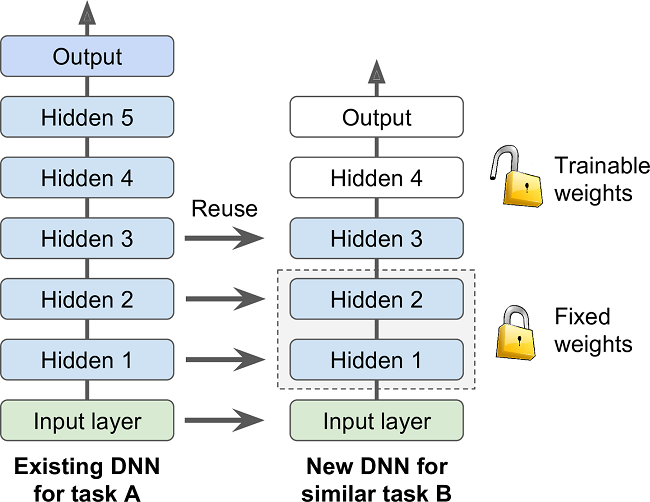
</p>
Figure 11-4. Reusing pretrained layers

If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, **transfer learning will work best when the inputs have similar low-level features**

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse

The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). **For very similar tasks, try keeping all the hidden layers and just replacing the output layer**

**Try freezing all the reused layers first** (i.e., make their weights non trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves

**The more training data you have, the more layers you can unfreeze**. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top


## Transfer Learning with Keras

Let’s look at an example. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A

You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirt, negative=sandal). Your dataset is quite small; you only have 200 labeled images

When you train a new model for this task (let’s call it model B) with the same architecture as model A, it performs reasonably well (97.2% accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more, you realize that your task is quite similar to task A, so perhaps transfer learning can help



Let's split the fashion MNIST training set in two:

* X_train_A: all images of all items except for sandals and shirts (classes 5 and 6)

* X_train_B: a much smaller training set of just the first 200 images of sandals or shirts

The validation set and the test set are also split this way, but without restricting the number of images

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts)

However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter)

In [28]:
def split_dataset(X, y):
  y_5_or_6 = (y == 5 ) | (y == 6) # sandals or shirts
  y_A = y[~y_5_or_6]
  y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
  y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?

  return ((X[~y_5_or_6], y_A),
          (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [29]:
X_train_A.shape

(43986, 28, 28)

In [30]:
X_train_B.shape

(200, 28, 28)

In [31]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [32]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [41]:
model_A.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

In [42]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [43]:
model_A.save('my_model_A.h5')